<a href="https://colab.research.google.com/github/zbrubaker/portfolio/blob/main/Project4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Intro

Zachary Brubaker

CS-4430

Project 4 -- Train and use a Generative Adversarial Network.

You can access this notebook at: 

References: https://realpython.com/generative-adversarial-networks/ 

Import the necessary libraries, set up the notebook to run using the GPU, and import the lfw dataset.

In [1]:
import torch
from torch import nn
from sklearn.datasets import fetch_lfw_people
import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import numpy as np

device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

!wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz 
!wget http://vis-www.cs.umass.edu/lfw/pairsDevTrain.txt
!wget http://vis-www.cs.umass.edu/lfw/pairsDevTest.txt
!wget http://vis-www.cs.umass.edu/lfw/pairs.txt

import tarfile
tfile = tarfile.open("lfw-deepfunneled.tgz", "r:gz")
tfile.extractall("lfw_home/.")

!mv lfw_home/lfw-deepfunneled lfw_home/lfw_funneled
!mv pairsDevTrain.txt lfw_home/.
!mv pairsDevTest.txt lfw_home/.
!mv pairs.txt lfw_home/.

from sklearn.datasets import fetch_lfw_people

--2023-02-18 04:05:25--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: ‘lfw-deepfunneled.tgz.1’

lfw-deepfunneled.tg 100%[===================>] 103.72M  91.5MB/s    in 1.1s    

2023-02-18 04:05:26 (91.5 MB/s) - ‘lfw-deepfunneled.tgz.1’ saved [108761145/108761145]

--2023-02-18 04:05:26--  http://vis-www.cs.umass.edu/lfw/pairsDevTrain.txt
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56579 (55K) [text/plain]
Saving to: ‘pairsDevTrain.txt’

pairsDevTrain.txt   100%[===================>]  55.25K  --.-KB/s    in 0.04s   

2023-02-18 04:05:26 (1.39 MB/

Import the images from the Faces in the Wild Dataset and load them into batches of size 33. Load the images into a dataloader with this batch size.

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=1, resize=0.5, data_home=".", download_if_missing=False)

# inputs = np.array(lfw_people.images)
inputs = np.array([lfw_people.images[i]/np.max(lfw_people.images[i]) for i in range(len(lfw_people.images))])
inputs = torch.from_numpy(inputs) #convert numpy arrays to a tensor
inputs = inputs[:,None, :] #add the channel dimension (
inputs = torch.nn.functional.interpolate(inputs, (64,64)) #resize image to 64x64

batch_size = 33
train_loader = torch.utils.data.DataLoader(inputs, batch_size=batch_size, shuffle=True)

#Make the GAN

##Define the generator. 

Make a generator class that extends the neural network class by creating a neural network that takes in latent space vectors, has three hidden layers (256, 512, 1024) and outputs an image. Use the ReLU activation function with a sigmoid activation function for the final result.

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 4096),
            nn.Sigmoid(),
        )
    #Runs the generator
    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 64, 64)
        return output
generator=Generator().to(device=device)

##Define the Discriminator

Make a discriminator class that takes in images, has three hidden layers of size 1024, 512, and 256, and gives a single output. Let the layers use the ReLU activation function. Allow for the sigmoid for the final activation function decision.

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    #runs the discriminator
    def forward(self, x):
        x = x.view(x.size(0), 4096)
        output = self.model(x)
        return output
discriminator = Discriminator().to(device=device)

#Train the Model

Define Constants to be used in the training. BCE will be the loss function used to measure inaccuracy. The Adam Optimizer will be used to update the weights.

In [5]:
lr = 0.0001
num_epochs = 100
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

## Train the Discriminator.



Only train the discriminator for one epoch to keep the discriminator from getting too good. Training the discriminator for one epoch gave me the best results. 

In [6]:
for epoch in range(1):
    for n, (images) in enumerate(train_loader):
    
        #Generate real data for the discriminator
        images = images.to(device=device)

        imageLabels = torch.ones((batch_size, 1)).to(device=device)

        #generate a random set of latent vectors
        latentSamples = torch.randn((batch_size, 100)).to(device=device)

        #generate a batch of images from these random latent vectors
        fakeImages = generator(latentSamples)

        #Make a set of labels for the fake images
        fakeLabels = torch.zeros((batch_size, 1)).to(device=device)

        # Combine the samples of real and fake images
        allSamples = torch.cat((images, fakeImages))
        allSamplesLabels = torch.cat((imageLabels, fakeLabels))

        #Run the batch through the discriminator
        discriminator.zero_grad()
        
        # get discriminator output on the batch of real images and the generated images
        discriminatorRes = discriminator(allSamples)

        #average the loss (BCE) of real images with real labels and generated images with fake labels
        loss_discriminator = loss_function(discriminatorRes, allSamplesLabels)
        loss_discriminator.backward()
        #step the discriminator optimizer here
        optimizer_discriminator.step()
        
        if n == batch_size - 1:
          print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")

Epoch: 0 Loss D.: 0.2663954496383667


##Train the Generator

Train the generator for all 100 epochs of training. Feed the generator random latent samples, run the images through the discriminator, and train the generator.

In [7]:
for epoch in range(num_epochs):
    for n, (images) in enumerate(train_loader):
      
      #Generate Samples in Latent Space
      latentSamples = torch.randn((batch_size, 100)).to(device=device)
      
      #Get samples from the generator
      generator.zero_grad()
      genImages = generator(latentSamples)

      #Make a set of labels for the fake images
      fakeLabels = torch.zeros((batch_size, 1)).to(device=device)

      #Discriminator Output
      discriminatorResult = discriminator(genImages)

      #Train the Generator
      lossGenerator = loss_function(discriminatorResult, fakeLabels)
      lossGenerator.backward()
      optimizer_generator.step()

      if n == batch_size - 1:
        print(f"Epoch: {epoch} Loss G.: {lossGenerator}")

Epoch: 0 Loss G.: 3.2277075661113486e-06
Epoch: 1 Loss G.: 9.392252309226023e-08
Epoch: 2 Loss G.: 1.2643409874613099e-08
Epoch: 3 Loss G.: 7.224805642636056e-09
Epoch: 4 Loss G.: 7.224805642636056e-09
Epoch: 5 Loss G.: 3.612402821318028e-09
Epoch: 6 Loss G.: 0.0
Epoch: 7 Loss G.: 5.418604676066252e-09
Epoch: 8 Loss G.: 1.806201410659014e-09
Epoch: 9 Loss G.: 0.0
Epoch: 10 Loss G.: 0.0
Epoch: 11 Loss G.: 0.0
Epoch: 12 Loss G.: 0.0
Epoch: 13 Loss G.: 0.0
Epoch: 14 Loss G.: 0.0
Epoch: 15 Loss G.: 0.0
Epoch: 16 Loss G.: 0.0
Epoch: 17 Loss G.: 0.0
Epoch: 18 Loss G.: 0.0
Epoch: 19 Loss G.: 0.0
Epoch: 20 Loss G.: 0.0
Epoch: 21 Loss G.: 0.0
Epoch: 22 Loss G.: 0.0
Epoch: 23 Loss G.: 0.0
Epoch: 24 Loss G.: 0.0
Epoch: 25 Loss G.: 0.0
Epoch: 26 Loss G.: 0.0
Epoch: 27 Loss G.: 0.0
Epoch: 28 Loss G.: 0.0
Epoch: 29 Loss G.: 0.0
Epoch: 30 Loss G.: 0.0
Epoch: 31 Loss G.: 0.0
Epoch: 32 Loss G.: 0.0
Epoch: 33 Loss G.: 7.224806530814476e-09
Epoch: 34 Loss G.: 0.0
Epoch: 35 Loss G.: 0.0
Epoch: 36 Loss G.:

#The Result

Now, show the result of the generator by graphing a few images. I will show onw example when the images are smaller, and one example when the images are larger. 

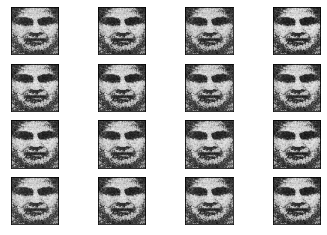

In [8]:
latentSamples = torch.randn(batch_size, 100).to(device=device)
fakeImages = generator(latentSamples)

#Discriminator
discriminatorResult = discriminator(genImages)
discriminatorResult = discriminatorResult.cpu().data.numpy()
fakeImages = fakeImages.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(fakeImages[i].reshape(64, 64), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])


/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


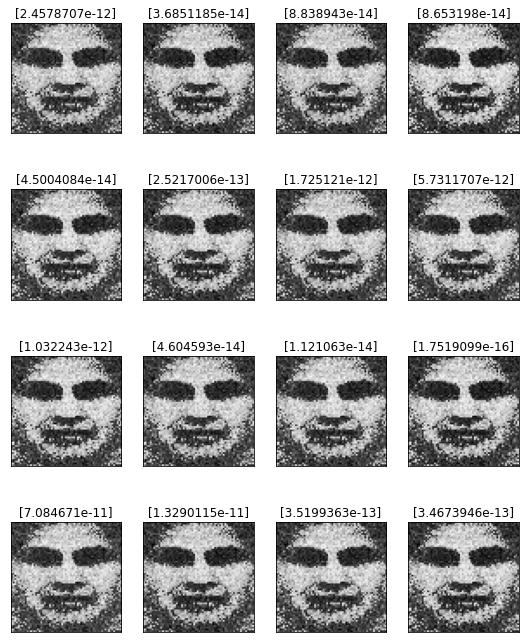

In [9]:
def plot_gallery(eigenVectors, h, w, n_row=4, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.title(discriminatorResult[i])
        plt.imshow(eigenVectors[i].reshape(64, 64), cmap="gray_r")
        plt.xticks(())
        plt.yticks(())


plot_gallery(fakeImages, 4, 4)

##Closing Thoughts

The result clearly shows the eyes, nose, mouth, head shape, and other facial features in the generated images. The labels show the discriminator value for each image. Each image has a very low discriminator value that is almost 0.  This indicates that the discriminator was not fooled by the generator's fake images. The discriminator may be too strong right off the bat. It also indicates a problem with my training. The combination of a low generator loss value at the start of training (near 0) and the low value of the discriminator at the end indicates that the generator likely had difficulty fooling the discriminator. They probably did not act in a very adversarial manner. 

Another problem is that all of the resultant faces turned out similar. It is possible that the generator has zeroed out some weights.

Overall, the faces that are generated are very good, even though they clearly do not fool the discriminator. In this project, I imported faces from the faces in the wild dataset. Then, I defined the generator and discriminator neural networks. Then I trained the discriminator for one iteration (epoch). Next, I trained the generator by running the generator for 100 epochs. Finally, I created fake images from noise data and analyzed the results.